In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Paths
DATA_PATH = "../data/thai_road_accident_2019_2022.csv"
MODEL_PATH = "best_model.pkl"
PREPROCESSOR_PATH = "preprocessor.pkl"
METADATA_PATH = "model_metadata.json"

RANDOM_STATE = 42
TEST_SIZE = 0.2

# Optional libs
try:
    from imblearn.over_sampling import SMOTE
    IMB = True
except:
    IMB = False

try:
    import lightgbm as lgb
    LGB = True
except:
    LGB = False

import xgboost as xgb

from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import json
import joblib


In [1]:
# Paths
DATA_PATH = "../data/thai_road_accident_2019_2022.csv"
MODEL_PATH = "best_model.pkl"
PREPROCESSOR_PATH = "preprocessor.pkl"
METADATA_PATH = "model_metadata.json"

RANDOM_STATE = 42
TEST_SIZE = 0.2

In [6]:
# Optional libs
try:
    from imblearn.over_sampling import SMOTE
    IMB = True
except:
    IMB = False

try:
    import lightgbm as lgb
    LGB = True
except:
    LGB = False

import xgboost as xgb

from sklearn.model_selection import (
    train_test_split, StratifiedKFold,
    RandomizedSearchCV, GridSearchCV
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, roc_auc_score,
    ConfusionMatrixDisplay, roc_curve
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import json
import joblib

In [33]:
df = pd.read_csv(DATA_PATH)

In [34]:
df.columns

Index(['acc_code', 'incident_datetime', 'report_datetime', 'province_th',
       'province_en', 'agency', 'route', 'vehicle_type', 'presumed_cause',
       'accident_type', 'number_of_vehicles_involved', 'number_of_fatalities',
       'number_of_injuries', 'weather_condition', 'latitude', 'longitude',
       'road_description', 'slope_description'],
      dtype='object')

In [35]:
df['route'].nunique()

3882

In [36]:
df['province_en'].nunique()

78

In [37]:
df['accident_type'].nunique()

11

In [38]:
df['presumed_cause'].nunique()

54

Counts:
 severity
low     71600
high    10135
Name: count, dtype: int64


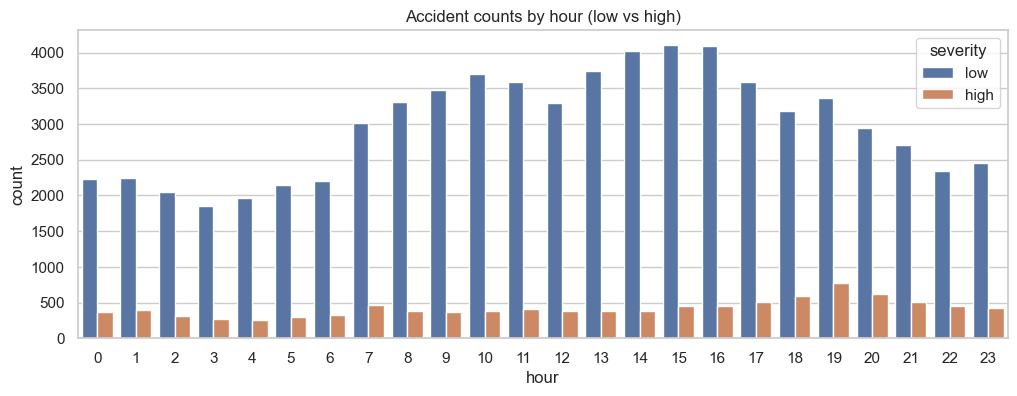

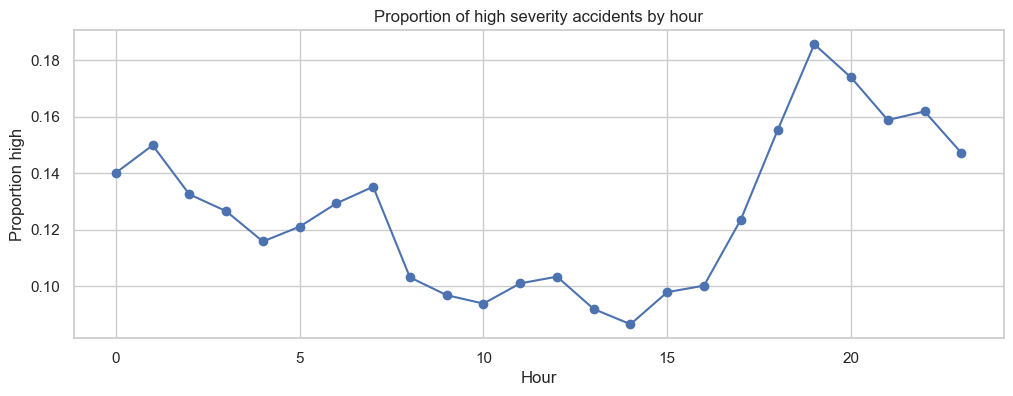

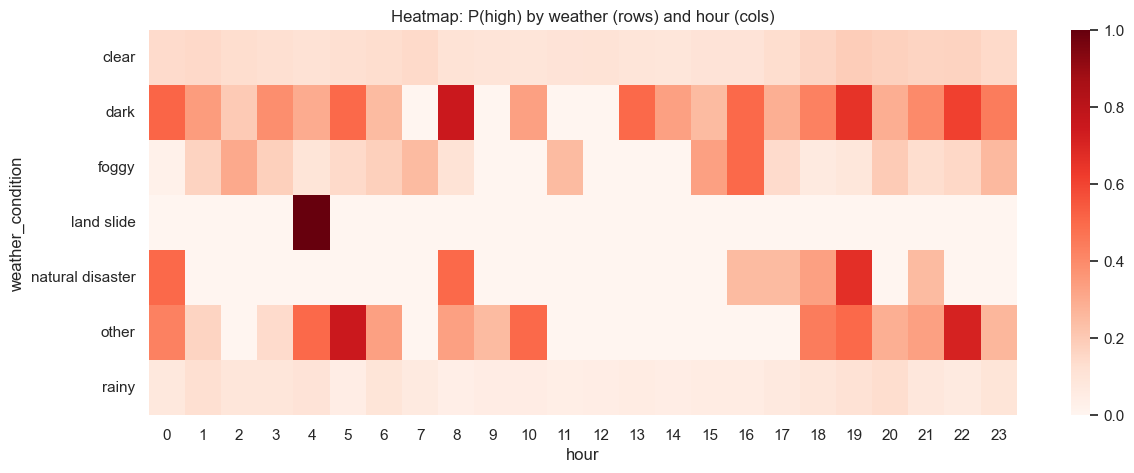

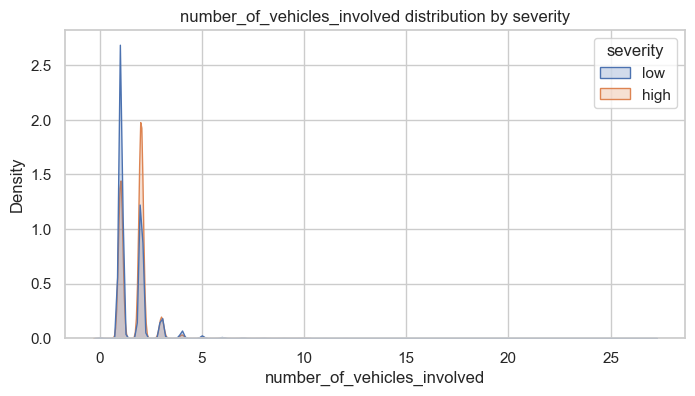

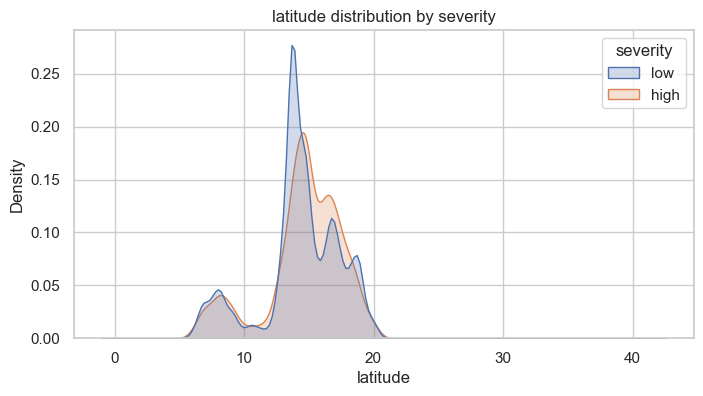

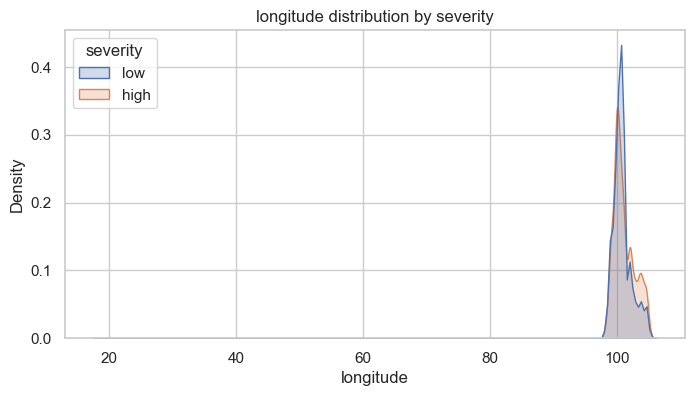

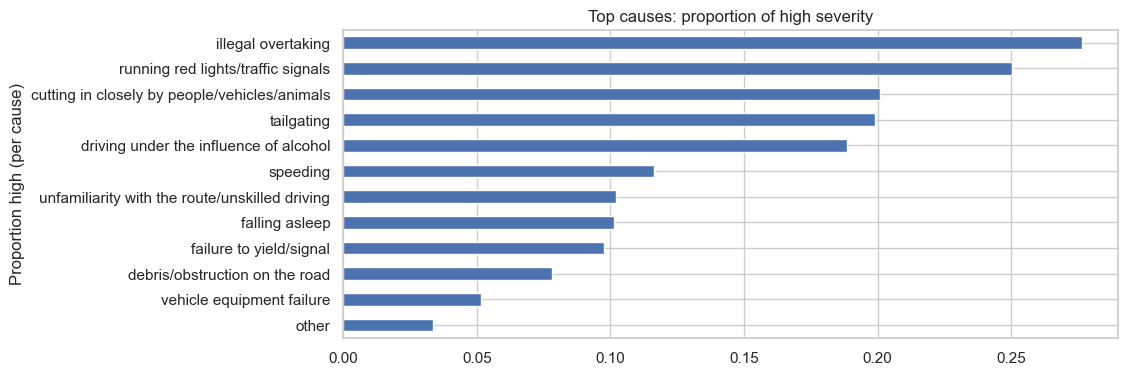

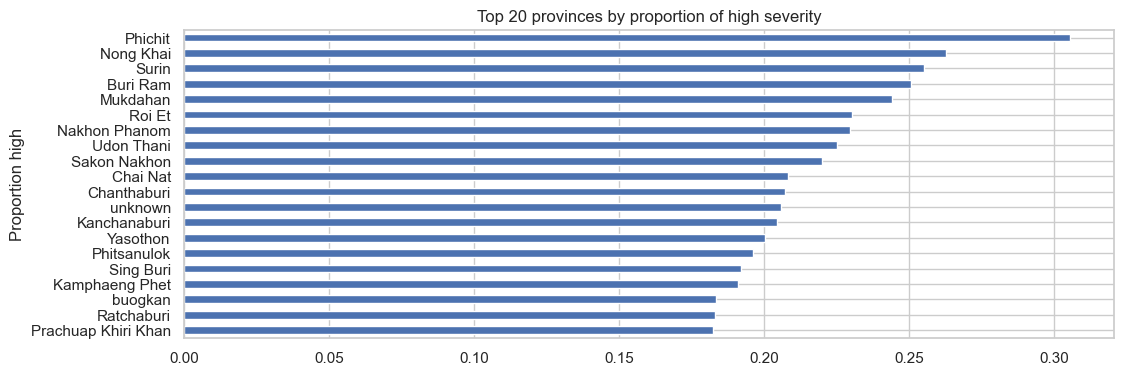

In [12]:
df = df.drop_duplicates().reset_index(drop=True)
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
df = df.dropna(subset=['incident_datetime']).reset_index(drop=True)

df['severity'] = np.where(df.get('number_of_fatalities', 0) > 0, 'high', 'low')
df['severity'] = pd.Categorical(df['severity'], categories=['low', 'high'], ordered=True)

# ------------------------------------------
# Time features
# ------------------------------------------
df['hour'] = df['incident_datetime'].dt.hour
df['weekday'] = df['incident_datetime'].dt.weekday
df['month'] = df['incident_datetime'].dt.month

print("Counts:\n", df['severity'].value_counts())

# ------------------------------------------
# A: Simple counts by hour
# ------------------------------------------
plt.figure(figsize=(12, 4))
sns.countplot(
    x='hour',
    hue='severity',
    data=df,
    order=sorted(df['hour'].dropna().unique())
)
plt.title('Accident counts by hour (low vs high)')
plt.show()

# ------------------------------------------
# B: Proportion of high by hour
# ------------------------------------------
hour_prop = df.groupby('hour')['severity'].value_counts(normalize=True).unstack(fill_value=0)

if 'high' in hour_prop.columns:
    plt.figure(figsize=(12, 4))
    plt.plot(hour_prop.index, hour_prop['high'], marker='o')
    plt.ylabel('Proportion high')
    plt.xlabel('Hour')
    plt.title('Proportion of high severity accidents by hour')
    plt.grid(True)
    plt.show()

# ------------------------------------------
# C: Heatmap — P(high) by weather × hour
# ------------------------------------------
if 'weather_condition' in df.columns:
    # create binary column for pivot
    df['is_high'] = (df['severity'] == 'high').astype(int)

    top_weather = df['weather_condition'].value_counts().nlargest(8).index.tolist()

    filtered = df[df['weather_condition'].isin(top_weather)]

    pivot = (
        filtered.pivot_table(
            index='weather_condition',
            columns='hour',
            values='is_high',
            aggfunc='mean'
        )
        .fillna(0)
    )

    plt.figure(figsize=(14, 5))
    sns.heatmap(
        pivot,
        cmap='Reds',
        vmin=0,
        vmax=pivot.values.max(),
        annot=False
    )
    plt.title('Heatmap: P(high) by weather (rows) and hour (cols)')
    plt.show()

# ------------------------------------------
# D: Numeric distributions (vehicles, lat/lon, grid)
# ------------------------------------------
num_cols = []

if 'number_of_vehicles_involved' in df.columns:
    num_cols.append('number_of_vehicles_involved')

if 'latitude' in df.columns and 'longitude' in df.columns:
    num_cols += ['latitude', 'longitude']

if 'grid_count' in df.columns:
    num_cols.append('grid_count')

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(data=df, x=col, hue='severity', fill=True, common_norm=False)
    plt.title(f'{col} distribution by severity')
    plt.show()

# ------------------------------------------
# E: Top causes vs severity
# ------------------------------------------
if 'presumed_cause' in df.columns:
    top_causes = df['presumed_cause'].value_counts().nlargest(12).index
    ct = pd.crosstab(
        df.loc[df['presumed_cause'].isin(top_causes), 'presumed_cause'],
        df['severity'],
        normalize='index'
    ).sort_values('high', ascending=False)

    ct['high'].sort_values().plot(kind='barh', figsize=(10, 4))
    plt.ylabel('Proportion high (per cause)')
    plt.title('Top causes: proportion of high severity')
    plt.show()

# ------------------------------------------
# F: Province-level high proportion
# ------------------------------------------
if 'province_en' in df.columns:
    prov = df.groupby('province_en')['severity'].value_counts(normalize=True).unstack(fill_value=0)
    prov = prov.sort_values('high', ascending=False).head(20)

    prov['high'].sort_values().plot(kind='barh', figsize=(12, 4))
    plt.title('Top 20 provinces by proportion of high severity')
    plt.ylabel('Proportion high')
    plt.show()

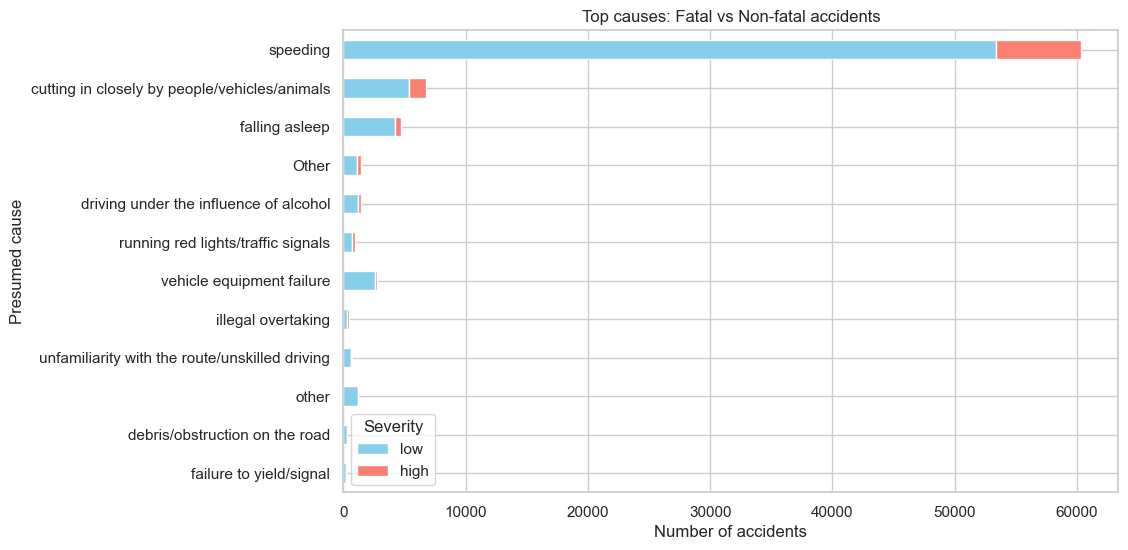

In [23]:
if 'presumed_cause' in df.columns:
    top_causes = df['presumed_cause'].value_counts().nlargest(12).index
    ct_counts = pd.crosstab(
        df.loc[df['presumed_cause'].isin(top_causes), 'presumed_cause'],
        df['severity']
    ).sort_values('high', ascending=True)  # sort by high severity for plotting

    # Stacked bar plot
    ct_counts.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.xlabel('Number of accidents')
    plt.ylabel('Presumed cause')
    plt.title('Top causes: Fatal vs Non-fatal accidents')
    plt.legend(title='Severity')
    plt.show()


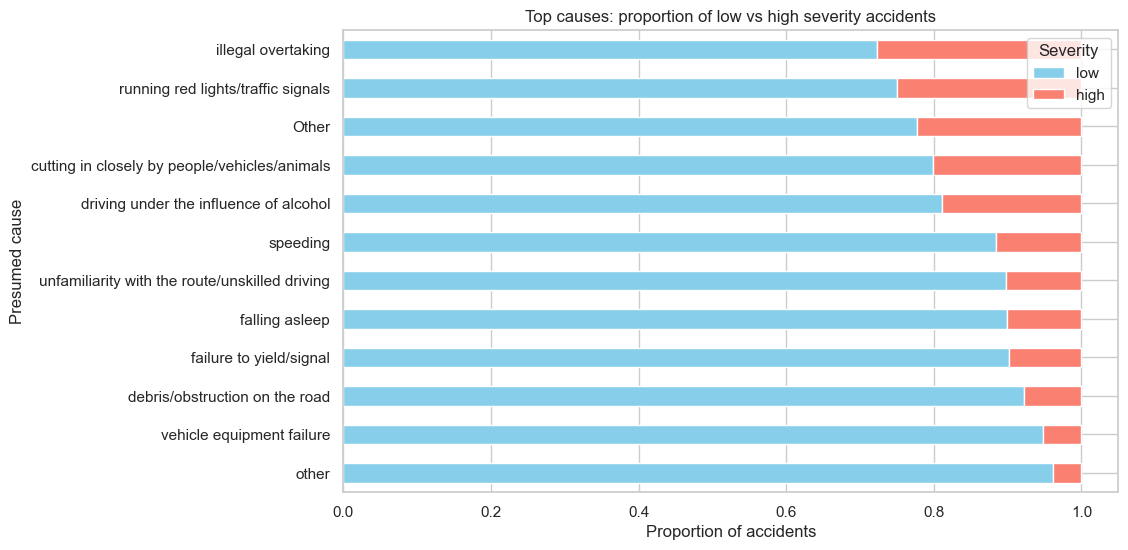

In [25]:
if 'presumed_cause' in df.columns:
    top_causes = df['presumed_cause'].value_counts().nlargest(12).index
    ct_prop = pd.crosstab(
        df.loc[df['presumed_cause'].isin(top_causes), 'presumed_cause'],
        df['severity'],
        normalize='index'  # normalize per row to get proportions
    ).sort_values('high', ascending=True)

    # 100% stacked bar plot
    ct_prop.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.xlabel('Proportion of accidents')
    plt.ylabel('Presumed cause')
    plt.title('Top causes: proportion of low vs high severity accidents')
    plt.legend(title='Severity')
    plt.show()


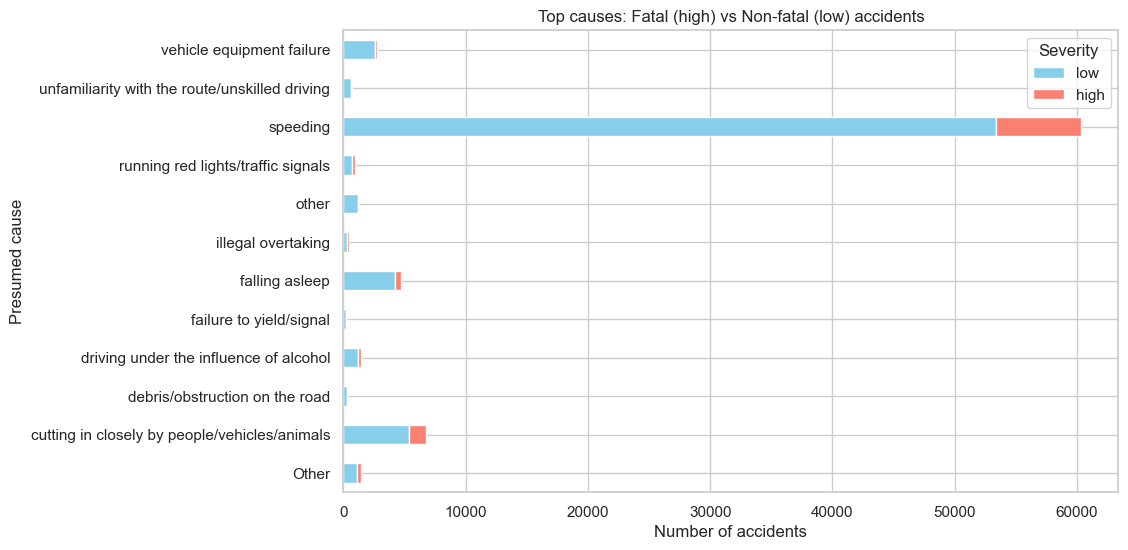

In [27]:
if 'presumed_cause' in df.columns:
    top_causes = df['presumed_cause'].value_counts().nlargest(12).index
    ct_counts = pd.crosstab(
        df.loc[df['presumed_cause'].isin(top_causes), 'presumed_cause'],
        df['severity']
    )[["low","high"]]  # explicitly just two severities

    ct_counts.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.xlabel('Number of accidents')
    plt.ylabel('Presumed cause')
    plt.title('Top causes: Fatal (high) vs Non-fatal (low) accidents')
    plt.legend(title='Severity')
    plt.show()


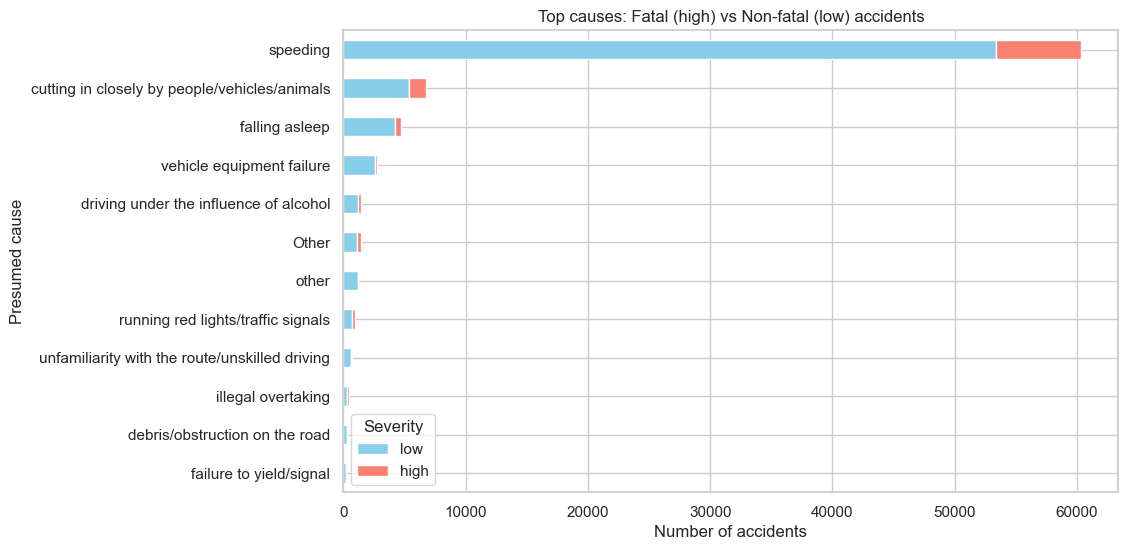

In [28]:
if 'presumed_cause' in df.columns:
    # Select top 12 causes
    top_causes = df['presumed_cause'].value_counts().nlargest(12).index
    
    # Crosstab counts of low vs high severity
    ct_counts = pd.crosstab(
        df.loc[df['presumed_cause'].isin(top_causes), 'presumed_cause'],
        df['severity']
    )[["low", "high"]]  # only low/high

    # Sort by total accidents (ascending)
    ct_counts['total'] = ct_counts.sum(axis=1)
    ct_counts = ct_counts.sort_values('total', ascending=True)
    ct_counts = ct_counts.drop(columns='total')  # remove helper column

    # Plot stacked horizontal bar
    ct_counts.plot(kind='barh', stacked=True, figsize=(10, 6), color=['skyblue', 'salmon'])
    plt.xlabel('Number of accidents')
    plt.ylabel('Presumed cause')
    plt.title('Top causes: Fatal (high) vs Non-fatal (low) accidents')
    plt.legend(title='Severity')
    plt.show()


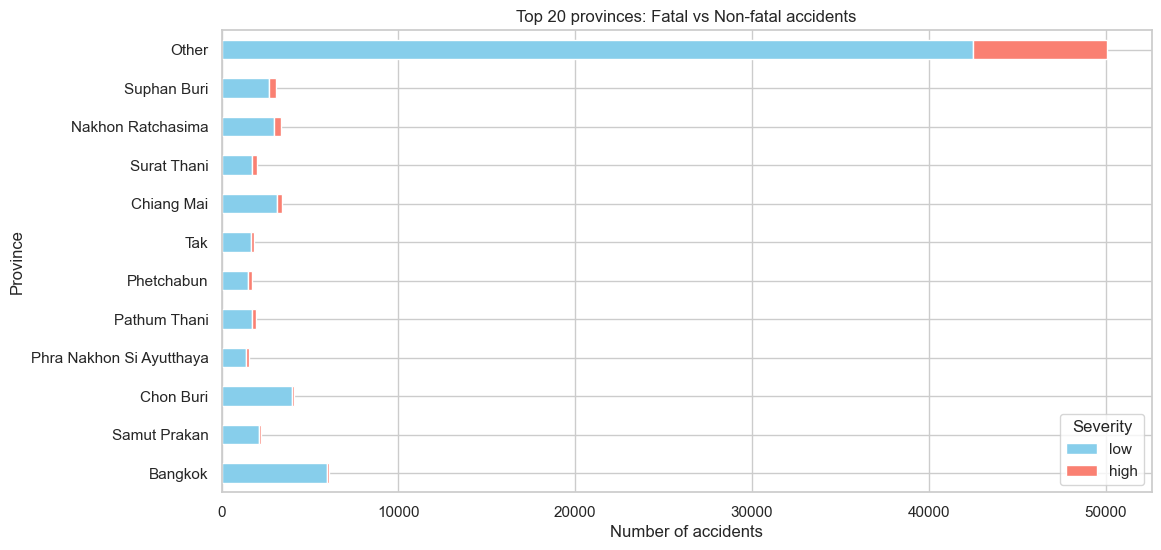

In [24]:
if 'province_en' in df.columns:
    prov_counts = df.groupby('province_en')['severity'].value_counts().unstack(fill_value=0)
    prov_counts = prov_counts.sort_values('high', ascending=True).tail(20)  # top 20 by high severity

    # Stacked bar plot
    prov_counts.plot(kind='barh', stacked=True, figsize=(12, 6), color=['skyblue', 'salmon'])
    plt.xlabel('Number of accidents')
    plt.ylabel('Province')
    plt.title('Top 20 provinces: Fatal vs Non-fatal accidents')
    plt.legend(title='Severity')
    plt.show()


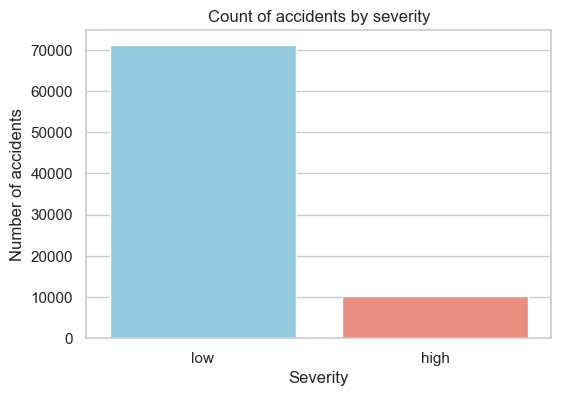

In [29]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='severity', order=['low', 'high'], palette=['skyblue', 'salmon'])
plt.xlabel('Severity')
plt.ylabel('Number of accidents')
plt.title('Count of accidents by severity')
plt.show()

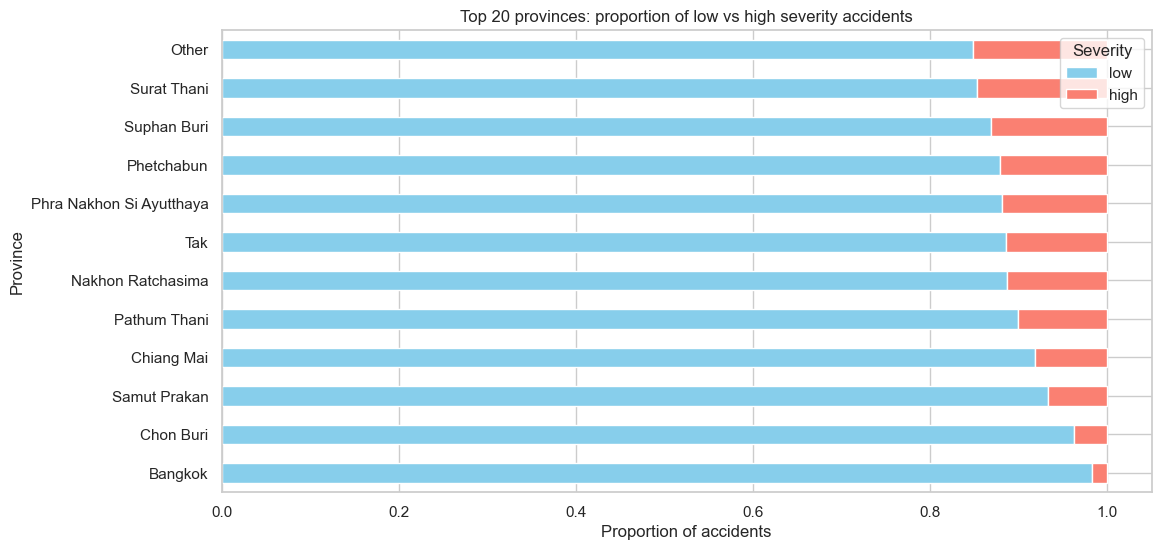

In [26]:
if 'province_en' in df.columns:
    prov_prop = df.groupby('province_en')['severity'].value_counts(normalize=True).unstack(fill_value=0)
    prov_prop = prov_prop.sort_values('high', ascending=True).tail(20)  # top 20 by high severity

    # 100% stacked bar plot
    prov_prop.plot(kind='barh', stacked=True, figsize=(12, 6), color=['skyblue', 'salmon'])
    plt.xlabel('Proportion of accidents')
    plt.ylabel('Province')
    plt.title('Top 20 provinces: proportion of low vs high severity accidents')
    plt.legend(title='Severity')
    plt.show()


In [13]:
# 2_feature_engineering.py cell
USE_CYCLIC = True   # flip to False to stay with base-paper raw features

# assume df from previous cell present
if USE_CYCLIC:
    df['hour_sin'] = np.sin(2*np.pi*df['hour']/24)
    df['hour_cos'] = np.cos(2*np.pi*df['hour']/24)
    df['month_sin'] = np.sin(2*np.pi*df['month']/12)
    df['month_cos'] = np.cos(2*np.pi*df['month']/12)
    df['weekday_sin'] = np.sin(2*np.pi*df['weekday']/7)
    df['weekday_cos'] = np.cos(2*np.pi*df['weekday']/7)
    # drop raw columns to avoid redundancy
    df.drop(columns=['hour','month','weekday'], inplace=True)

# spatial bins and density (if not done)
if {'latitude','longitude'}.issubset(df.columns) and 'grid_count' not in df.columns:
    df['lat_round3'] = df['latitude'].round(3)
    df['lon_round3'] = df['longitude'].round(3)
    grid_counts = df.groupby(['lat_round3','lon_round3']).size().rename('grid_count').reset_index()
    df = df.merge(grid_counts, on=['lat_round3','lon_round3'], how='left')
    df['grid_count'] = df['grid_count'].fillna(0).astype(int)

# top-N grouping for high-cardinality categorical cols
CAT_COLS = ['province_en','vehicle_type','presumed_cause','accident_type','weather_condition','road_description','slope_description']
TOPN=12
for c in CAT_COLS:
    if c in df.columns:
        df[c] = df[c].fillna('Missing').astype(str)
        top = df[c].value_counts().nlargest(TOPN).index
        df[c] = df[c].where(df[c].isin(top), other='Other')

# interactions
if 'vehicle_type' in df.columns and 'weather_condition' in df.columns:
    df['veh_weather'] = df['vehicle_type'] + "__" + df['weather_condition']
    top = df['veh_weather'].value_counts().nlargest(30).index
    df['veh_weather'] = df['veh_weather'].where(df['veh_weather'].isin(top), other='Other')

# final quick check
print("Columns after FE:", df.columns.tolist())


Columns after FE: ['acc_code', 'incident_datetime', 'report_datetime', 'province_th', 'province_en', 'agency', 'route', 'vehicle_type', 'presumed_cause', 'accident_type', 'number_of_vehicles_involved', 'number_of_fatalities', 'number_of_injuries', 'weather_condition', 'latitude', 'longitude', 'road_description', 'slope_description', 'severity', 'is_high', 'hour_sin', 'hour_cos', 'month_sin', 'month_cos', 'weekday_sin', 'weekday_cos', 'lat_round3', 'lon_round3', 'grid_count', 'veh_weather']


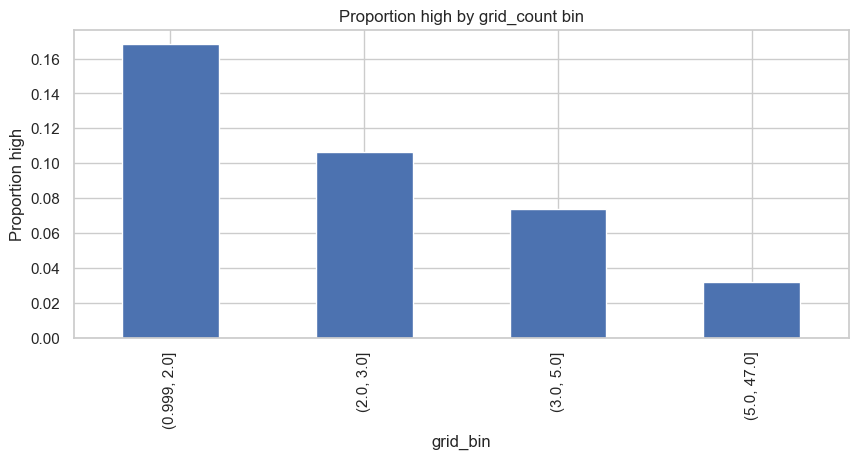

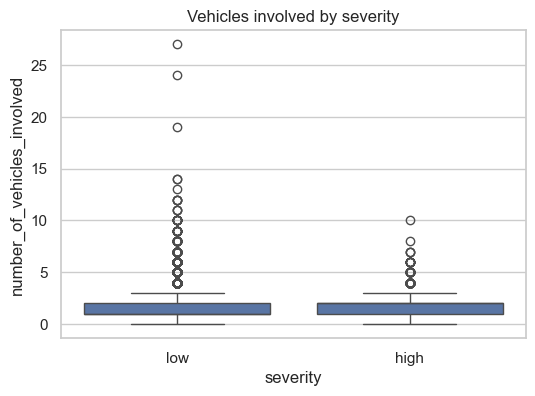

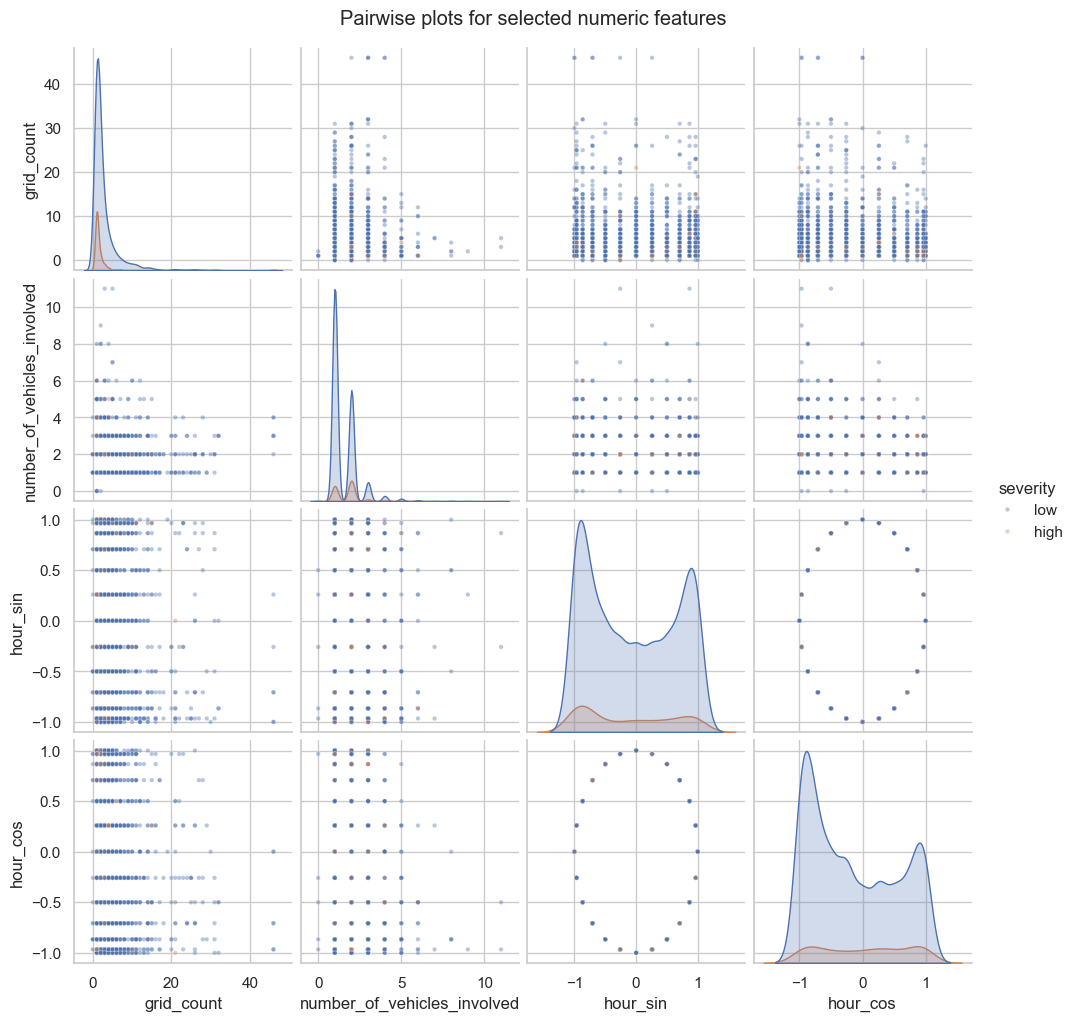

In [14]:
# 3_more_eda.py cell
# A) Proportion of high by grid_count (binned)
if 'grid_count' in df.columns:
    df['grid_bin'] = pd.qcut(df['grid_count'].replace(0,np.nan).fillna(0)+1, q=6, duplicates='drop')
    grid_stats = df.groupby('grid_bin')['severity'].value_counts(normalize=True).unstack(fill_value=0)
    if 'high' in grid_stats.columns:
        grid_stats['high'].plot(kind='bar', figsize=(10,4))
        plt.title('Proportion high by grid_count bin')
        plt.ylabel('Proportion high')
        plt.show()

# B) Boxplot of number_of_vehicles_involved by severity
if 'number_of_vehicles_involved' in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='severity', y='number_of_vehicles_involved', data=df)
    plt.title('Vehicles involved by severity')
    plt.show()

# C) Pairwise sample for small set of features with jitter (sample to speed up)
sample = df.sample(min(5000, len(df)), random_state=42)
sel = [c for c in ['grid_count','number_of_vehicles_involved','hour_sin','hour_cos'] if c in sample.columns]
if sel:
    sns.pairplot(sample, vars=sel, hue='severity', plot_kws={'alpha':0.4, 's':10})
    plt.suptitle('Pairwise plots for selected numeric features', y=1.02)
    plt.show()

# D) Precision-recall baseline estimate by naive rule:
# e.g., "predict high whenever hour in high_hours set" to show tradeoff (toy baseline)
high_hours = list(df.groupby('hour').apply(lambda g: (g['severity']=='high').mean()).sort_values(ascending=False).head(3).index) if 'hour' in df.columns else []
if high_hours:
    y_true = (df['severity']=='high').astype(int)
    y_pred_rule = df['hour'].isin(high_hours).astype(int)
    from sklearn.metrics import precision_score, recall_score
    print("Toy-hour-rule precision, recall:", precision_score(y_true, y_pred_rule), recall_score(y_true, y_pred_rule))


In [15]:
# 4_split.py cell
from sklearn.model_selection import train_test_split

# If you want time-based split:
if 'incident_datetime' in df.columns and df['incident_datetime'].notna().sum() > 0:
    df['year'] = pd.to_datetime(df.get('incident_datetime'), errors='coerce').dt.year
    if 2019 in df['year'].unique() and 2022 in df['year'].unique():
        train_mask = df['year'] <= 2021
        test_mask = df['year'] == 2022
        X = df.drop(columns=['severity'])
        y = (df['severity']=='high').astype(int)
        X_train = X[train_mask].drop(columns=['incident_datetime','year'], errors='ignore')
        X_test = X[test_mask].drop(columns=['incident_datetime','year'], errors='ignore')
        y_train = y[train_mask]
        y_test = y[test_mask]
        print("Time-based split sizes:", X_train.shape, X_test.shape)
    else:
        # fallback to stratified
        X = df.drop(columns=['severity'])
        y = (df['severity']=='high').astype(int)
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
else:
    X = df.drop(columns=['severity'])
    y = (df['severity']=='high').astype(int)
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

print("Train dist:", y_train.value_counts(normalize=True))


Time-based split sizes: (60703, 29) (21032, 29)
Train dist: severity
0    0.870517
1    0.129483
Name: proportion, dtype: float64


In [18]:
X.isnull().sum()

acc_code                         0
incident_datetime                0
report_datetime                  0
province_th                      0
province_en                      0
agency                           0
route                            0
vehicle_type                     0
presumed_cause                   0
accident_type                    0
number_of_vehicles_involved      0
number_of_fatalities             0
number_of_injuries               0
weather_condition                0
latitude                       359
longitude                      359
road_description                 0
slope_description                0
is_high                          0
hour_sin                         0
hour_cos                         0
month_sin                        0
month_cos                        0
weekday_sin                      0
weekday_cos                      0
lat_round3                     359
lon_round3                     359
grid_count                       0
veh_weather         

In [17]:
# 5_preprocess.py cell
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object','category']).columns.tolist()

numeric_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scale', StandardScaler())
])
categorical_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_pipe, numeric_cols),
    ('cat', categorical_pipe, categorical_cols)
], remainder='drop', sparse_threshold=0)
# Fit on train to create transformers
preprocessor.fit(X_train)
# quick transform sizes
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)
print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)


MemoryError: Unable to allocate 23.6 GiB for an array with shape (60703, 52072) and data type float64

raw rows: 81735
Rows with missing lat/lon: 359
class counts: {'low': 71247, 'high': 10129}
Numeric features: ['number_of_vehicles_involved', 'latitude', 'longitude', 'lat_round3', 'lon_round3', 'grid_count', 'hour', 'weekday', 'month']
Categorical features: ['province_en', 'vehicle_type', 'presumed_cause', 'accident_type', 'weather_condition', 'road_description', 'slope_description']

Running cross-validated baselines (this will take some time)...

LR CV (mean over folds):
 recall: 0.7023  f1: 0.4294  auc: 0.8044

RF CV (mean over folds):
 recall: 0.1828  f1: 0.2855  auc: 0.8295

XGB CV (mean over folds):
 recall: 0.6884  f1: 0.4611  auc: 0.8293
[LightGBM] [Info] Number of positive: 8103, number of negative: 56997
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info

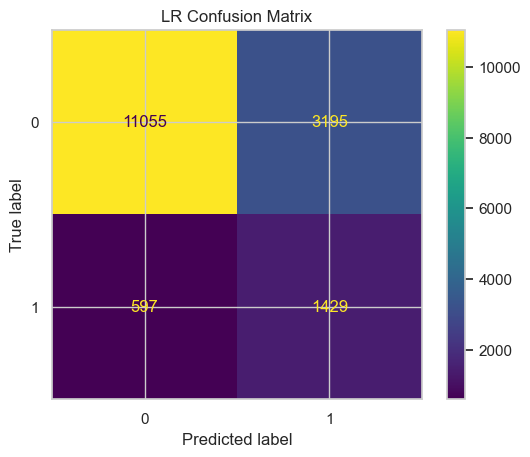


=== RF_baseline on hold-out ===
recall: 0.18756169792694966 f1: 0.2900763358778626 auc: 0.8287046812490257
              precision    recall  f1-score   support

           0     0.8950    0.9850    0.9379     14250
           1     0.6397    0.1876    0.2901      2026

    accuracy                         0.8857     16276
   macro avg     0.7674    0.5863    0.6140     16276
weighted avg     0.8633    0.8857    0.8572     16276



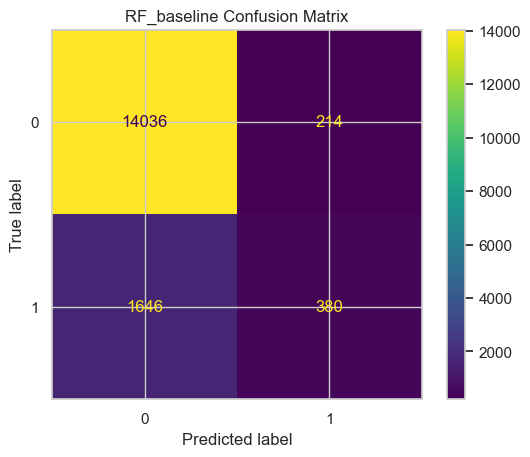


=== XGB_baseline on hold-out ===
recall: 0.7107601184600197 f1: 0.4698205546492659 auc: 0.833300912696351
              precision    recall  f1-score   support

           0     0.9519    0.8131    0.8770     14250
           1     0.3509    0.7108    0.4698      2026

    accuracy                         0.8003     16276
   macro avg     0.6514    0.7619    0.6734     16276
weighted avg     0.8770    0.8003    0.8263     16276



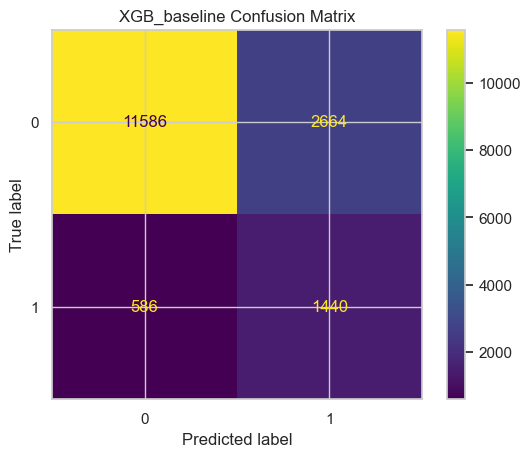


=== RF_tuned on hold-out ===
recall: 0.7660414610069102 f1: 0.4429223744292237 auc: 0.8285530905249303
              precision    recall  f1-score   support

           0     0.9580    0.7593    0.8472     14250
           1     0.3115    0.7660    0.4429      2026

    accuracy                         0.7601     16276
   macro avg     0.6348    0.7627    0.6450     16276
weighted avg     0.8776    0.7601    0.7968     16276



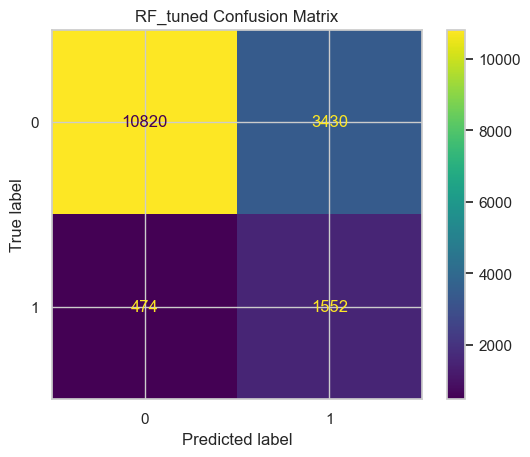


=== XGB_tuned on hold-out ===
recall: 0.8894373149062191 f1: 0.938297318406665 auc: 0.9988670788521155
              precision    recall  f1-score   support

           0     0.9845    0.9991    0.9917     14250
           1     0.9928    0.8894    0.9383      2026

    accuracy                         0.9854     16276
   macro avg     0.9887    0.9443    0.9650     16276
weighted avg     0.9855    0.9854    0.9851     16276



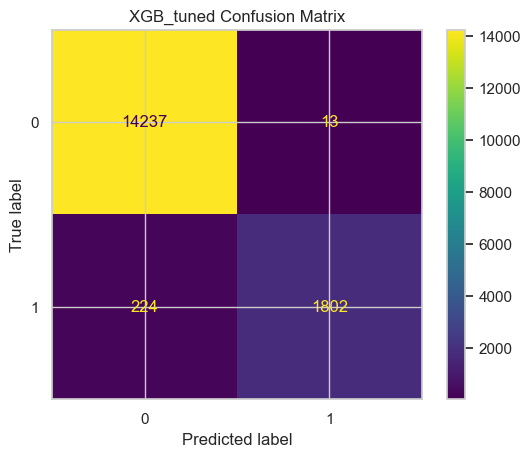


=== LGB_tuned on hold-out ===
recall: 0.7645607107601184 f1: 0.8553285477636665 auc: 0.993631769453248
              precision    recall  f1-score   support

           0     0.9675    0.9967    0.9819     14250
           1     0.9706    0.7646    0.8553      2026

    accuracy                         0.9678     16276
   macro avg     0.9690    0.8806    0.9186     16276
weighted avg     0.9679    0.9678    0.9661     16276



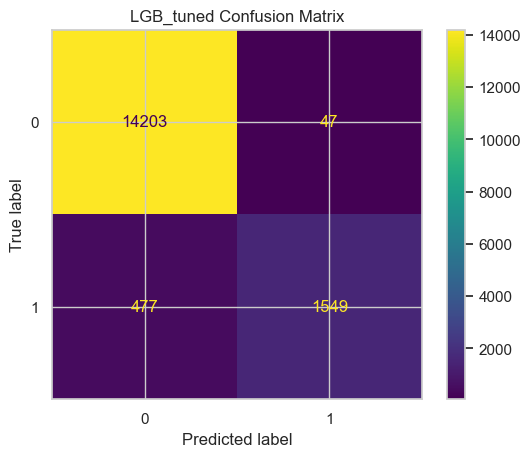


Selected best candidate: XGB_tuned
Saved best model and preprocessor for Option A.


In [21]:
# -----------------------------
# Option A: Raw time features pipeline + CV + RandomizedSearch (recall-focused)
# - Drops rows with missing lat/lon
# - Baseline CV for LR, RF, XGB, (LGB)
# - RandomizedSearchCV for RF and XGB (and LGB if available)
# -----------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Paths & config
DATA_PATH = "../data/thai_road_accident_2019_2022.csv"
RANDOM_STATE = 42
CV_FOLDS = 5
N_ITER_SEARCH = 20  # reduce to speed things up; increase later if desired

# optional libs
try:
    from imblearn.over_sampling import SMOTE
    IMB_AVAILABLE = True
except Exception:
    IMB_AVAILABLE = False

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
except Exception:
    LGB_AVAILABLE = False

import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib
import json

# -----------------------------
# 1) Load, drop lat/lon missing, quick target
# -----------------------------
df = pd.read_csv(DATA_PATH)
print("raw rows:", len(df))

# drop rows with missing lat/lon (option 1)
if {'latitude','longitude'}.issubset(df.columns):
    missing_loc = df['latitude'].isna() | df['longitude'].isna()
    print("Rows with missing lat/lon:", missing_loc.sum())
    df = df[~missing_loc].reset_index(drop=True)
else:
    print("Warning: no lat/lon in dataset; proceeding without spatial features.")

# target (binary: fatal > 0)
df['severity'] = np.where(df.get('number_of_fatalities', 0) > 0, 'high', 'low')
df['severity'] = pd.Categorical(df['severity'], categories=['low','high'], ordered=True)
print("class counts:", df['severity'].value_counts().to_dict())

# -----------------------------
# 2) Raw time features (Option A): keep hour/weekday/month for modeling (paper mode)
# -----------------------------
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
df = df.dropna(subset=['incident_datetime']).reset_index(drop=True)  # ensure valid datetimes
df['hour'] = df['incident_datetime'].dt.hour
df['weekday'] = df['incident_datetime'].dt.weekday
df['month'] = df['incident_datetime'].dt.month

# simple additional spatial feature (grid_count) if lat/lon present
if {'latitude','longitude'}.issubset(df.columns):
    df['lat_round3'] = df['latitude'].round(3)
    df['lon_round3'] = df['longitude'].round(3)
    grid_counts = df.groupby(['lat_round3','lon_round3']).size().rename('grid_count').reset_index()
    df = df.merge(grid_counts, on=['lat_round3','lon_round3'], how='left')
    df['grid_count'] = df['grid_count'].fillna(0).astype(int)

# shortlist features (Base-paper mode)
numeric_feats = [c for c in ['number_of_vehicles_involved','latitude','longitude','lat_round3','lon_round3','grid_count','hour','weekday','month'] if c in df.columns]
cat_feats = [c for c in ['province_en','vehicle_type','presumed_cause','accident_type','weather_condition','road_description','slope_description'] if c in df.columns]

print("Numeric features:", numeric_feats)
print("Categorical features:", cat_feats)

# reduce high-cardinality cats to top-N to avoid explosion
TOPN = 30
for c in list(cat_feats):
    top = df[c].value_counts().nlargest(TOPN).index
    df[c] = df[c].fillna('Missing').astype(str)
    df[c] = df[c].where(df[c].isin(top), other='Other')

# final feature list
FEATURES = numeric_feats + cat_feats
X = df[FEATURES].copy()
y = (df['severity'] == 'high').astype(int).values

# -----------------------------
# 3) Preprocessing: numeric impute+scale, categorical OHE (sparse)
# Important: use sparse OHE to avoid memory blowups
# -----------------------------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_pipe = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scale', StandardScaler())])
# Set OneHotEncoder to return sparse matrix to save memory
cat_pipe = Pipeline([('impute', SimpleImputer(strategy='constant', fill_value='Missing')),
                     ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=True))])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_feats),
    ('cat', cat_pipe, cat_feats)
], remainder='drop', sparse_threshold=0.3)  # keep sparse if any transformer outputs sparse

# -----------------------------
# 4) Baseline models (pipelines). Use class weight / scale_pos_weight for imbalance
# We'll evaluate with cross_validate (recall, f1, roc_auc)
# -----------------------------
cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
scoring = {'recall': make_scorer(recall_score), 'f1': make_scorer(f1_score), 'roc_auc': 'roc_auc'}

# Logistic Regression (balanced)
pipe_lr = Pipeline([('pre', preprocessor),
                    ('clf', LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE))])

# Random Forest (balanced)
pipe_rf = Pipeline([('pre', preprocessor),
                    ('clf', RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE))])

# XGBoost: use scale_pos_weight
pos = y.sum()
neg = len(y) - pos
scale_pos_weight = neg / pos if pos > 0 else 1.0
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                            random_state=RANDOM_STATE, scale_pos_weight=scale_pos_weight)
pipe_xgb = Pipeline([('pre', preprocessor), ('clf', xgb_clf)])

# LightGBM (if available) - use is_unbalance or class_weight
if LGB_AVAILABLE:
    lgb_clf = lgb.LGBMClassifier(random_state=RANDOM_STATE, is_unbalance=True)
    pipe_lgb = Pipeline([('pre', preprocessor), ('clf', lgb_clf)])
else:
    pipe_lgb = None

# Evaluate baselines via CV (this does not materialize full one-hot dense matrix; stays pipeline-safe)
baselines = {'LR': pipe_lr, 'RF': pipe_rf, 'XGB': pipe_xgb}
if pipe_lgb is not None:
    baselines['LGB'] = pipe_lgb

print("\nRunning cross-validated baselines (this will take some time)...")
cv_results = {}
for name, pipe in baselines.items():
    res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, return_train_score=False)
    cv_results[name] = res
    print(f"\n{name} CV (mean over folds):")
    print(" recall:", np.mean(res['test_recall']).round(4),
          " f1:", np.mean(res['test_f1']).round(4),
          " auc:", np.mean(res['test_roc_auc']).round(4))

# Store baseline results
joblib.dump(cv_results, "baseline_cv_results.joblib")

# -----------------------------
# 5) RandomizedSearchCV (recall-focused) for RF and XGB (and LGB if available)
#    Use moderate n_iter to save time; scoring='recall'
#    We do NOT use SMOTE here to stay memory-safe; class weights already used.
# -----------------------------
rand_searches = {}
np.random.seed(RANDOM_STATE)

# RF parameter distribution
rf_param_dist = {
    'clf__n_estimators': [200,400,800],
    'clf__max_depth': [None, 8, 12],
    'clf__min_samples_leaf': [1, 3, 5]
}
pipe_rf_search = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))])

print("\nRandomizedSearchCV for RandomForest (recall)...")
rnd_rf = RandomizedSearchCV(pipe_rf_search, rf_param_dist, n_iter=8, scoring='recall', cv=cv, random_state=RANDOM_STATE, verbose=1)
rnd_rf.fit(X, y)
print("RF best recall (cv):", rnd_rf.best_score_, "params:", rnd_rf.best_params_)
rand_searches['RF'] = rnd_rf

# XGBoost param distribution
xgb_param_dist = {
    'clf__n_estimators': [200, 500, 1000],
    'clf__learning_rate': [0.01, 0.05, 0.1],
    'clf__max_depth': [4, 6, 9],
    'clf__subsample': [0.6, 0.8, 1.0],
    'clf__colsample_bytree': [0.6, 0.8, 1.0],
    'clf__gamma': [0, 0.5, 1]
}
pipe_xgb_search = Pipeline([('pre', preprocessor), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))])
print("\nRandomizedSearchCV for XGBoost (recall)...")
rnd_xgb = RandomizedSearchCV(pipe_xgb_search, xgb_param_dist, n_iter=N_ITER_SEARCH, scoring='recall', cv=cv, random_state=RANDOM_STATE, verbose=1)
rnd_xgb.fit(X, y)
print("XGB best recall (cv):", rnd_xgb.best_score_, "params:", rnd_xgb.best_params_)
rand_searches['XGB'] = rnd_xgb

# Optional: LightGBM randomized search
if LGB_AVAILABLE:
    lgb_param_dist = {
        'clf__n_estimators': [200,500,1000],
        'clf__learning_rate': [0.01,0.05,0.1],
        'clf__num_leaves': [31, 64],
        'clf__subsample': [0.6, 0.8, 1.0]
    }
    pipe_lgb_search = Pipeline([('pre', preprocessor), ('clf', lgb.LGBMClassifier(random_state=RANDOM_STATE))])
    print("\nRandomizedSearchCV for LightGBM (recall)...")
    rnd_lgb = RandomizedSearchCV(pipe_lgb_search, lgb_param_dist, n_iter=N_ITER_SEARCH, scoring='recall', cv=cv, random_state=RANDOM_STATE, verbose=1)
    rnd_lgb.fit(X, y)
    print("LGB best recall (cv):", rnd_lgb.best_score_, "params:", rnd_lgb.best_params_)
    rand_searches['LGB'] = rnd_lgb

joblib.dump(rand_searches, "random_search_results_optionA.joblib")

# -----------------------------
# 6) Evaluate best candidates on a hold-out test set (time-split or random stratified)
#    We'll do a stratified random split here to get test metrics.
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print("\nHold-out test split sizes:", X_train.shape, X_test.shape, "pos rate test:", y_test.mean())

# select best estimators (from random searches) and evaluate on test set
candidates = {}
candidates['LR'] = pipe_lr.fit(X_train, y_train)
candidates['RF_baseline'] = pipe_rf.fit(X_train, y_train)
candidates['XGB_baseline'] = pipe_xgb.fit(X_train, y_train)
if 'RF' in rand_searches:
    candidates['RF_tuned'] = rand_searches['RF'].best_estimator_
if 'XGB' in rand_searches:
    candidates['XGB_tuned'] = rand_searches['XGB'].best_estimator_
if 'LGB' in rand_searches:
    candidates['LGB_tuned'] = rand_searches['LGB'].best_estimator_

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

test_reports = {}
for name, model in candidates.items():
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    print(f"\n=== {name} on hold-out ===")
    print("recall:", rec, "f1:", f1, "auc:", auc)
    print(classification_report(y_test, y_pred, digits=4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    # store
    test_reports[name] = {'recall': rec, 'f1': f1, 'auc': auc}

# Save best tuned model (by recall on CV or by test recall — choice)
# pick XGB_tuned if present else RF_tuned else XGB_baseline
best_name = None
if 'XGB_tuned' in test_reports:
    best_name = 'XGB_tuned'
elif 'RF_tuned' in test_reports:
    best_name = 'RF_tuned'
elif 'XGB_baseline' in test_reports:
    best_name = 'XGB_baseline'
else:
    best_name = 'LR'

print("\nSelected best candidate:", best_name)
best_model = candidates[best_name]
joblib.dump(best_model, "best_model_optionA.joblib")
joblib.dump(preprocessor, "preprocessor_optionA.joblib")
with open("metadata_optionA.json","w") as f:
    json.dump({'selected': best_name, 'cv_results_summary': {k: {m: float(np.mean(v['test_'+m])) for m in ['recall','f1','roc_auc']} for k,v in cv_results.items()}}, f, indent=2)

print("Saved best model and preprocessor for Option A.")
